In [14]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import math
import pandas as pd

In [135]:
twentyng_data = fetch_20newsgroups(subset='train',remove=('headers','footers','quotes'))
vectorizer = TfidfVectorizer(stop_words='english',max_df=0.95,min_df=2)
twentyng_data_vectors = vectorizer.fit_transform(twentyng_data.data)
twentyng_target = twentyng_data.target
ed_mat_20NG = euclidean_distances(twentyng_data_vectors)

In [15]:
def rangeQuery(ed_mat,eps,point_id):
    n_points = ed_mat.shape[1]
    seeds = []
    for i in range(0, n_points):
        if ed_mat[point_id][i]<eps:
            seeds.append(i)
    return seeds

In [17]:
def expandCluster(ed_mat,point_id,eps,min_points,cluster_label,c_id,neighbors):
    
    cluster_label[point_id] = c_id
    #print("point id:",point_id)
    #print("cluster cid:",c_id)
    
    neighbors_of_each_neighbor = []
    each_neighbor_id = 0
    #print("expanding clusters")
    while each_neighbor_id < len(neighbors):
        n = neighbors[each_neighbor_id]
        #print("each_neighbor_id:",each_neighbor_id)
        #print("cluster label:",cluster_label[each_neighbor_id])
        if(cluster_label[n] == -1): #noise
            cluster_label[n] = c_id
            
        elif cluster_label[n] == 0: #if label not assigned
             cluster_label[n] = c_id
             #print("expanding clusters for:",each_neighbor_id)
             neighbors_of_each_neighbor = rangeQuery(ed_mat,eps,n)
             #print(neighbors_of_each_neighbor)
             if len(neighbors_of_each_neighbor)>=min_points:
                for each_neighbor in neighbors_of_each_neighbor:
                    if each_neighbor not in neighbors:
                        neighbors.append(each_neighbor)
            
        each_neighbor_id+=1
        
        
    return cluster_label
            
        

In [18]:
def DBScan(x,ed_mat,eps,min_points):
    cluster_label ={}
    c_id = 0
    neighbor_point_list = []
    #initialize each cluster id ed_mat
    for point_id in range(ed_mat.shape[0]):
        cluster_label[point_id] = 0
    for point_id in range(ed_mat.shape[0]):
        if not(cluster_label[point_id]==0):
            continue
        neighbor_point_list = rangeQuery(ed_mat,eps,point_id)
        #print(len(neighbor_point_list))
        #print("created neighbors for:",point_id)
        #print("neighbors list:",neighbor_point_list)
        
        
        
        if len(neighbor_point_list) < min_points:    
            cluster_label[point_id] = -1 #considering it as noise
            
        else:  
                c_id+=1
            #for n in neighbor_point_list:
                #print("neighbor:",n)
                #print("cluster label:",cluster_label[n])
                cluster_label = expandCluster(ed_mat,point_id,eps,min_points,cluster_label,c_id,neighbor_point_list)
    return cluster_label 
    
    
    

In [19]:
def get_purity(clusters_label,N):
    purity=0.0
    for each_centroid in clusters_label:
        cluster_targets = clusters_label[each_centroid]
        frequency=Counter(cluster_targets)
        key_max=max(cluster_targets, key=cluster_targets.count)
        purity += frequency[key_max]
    purity = purity/N
    return purity

In [20]:
def calculate_purity(labels,target,N):
    clusters_label = {}
    label_len = N
    for i in range(N):
        if(labels[i]==-1):
            label_len=label_len-1
            continue
        clusters_label.setdefault(labels[i],[]).append(target[i])
    
    return get_purity(clusters_label,label_len)

In [21]:
### sum(m[i][j]) where 0<=i<=number of true clusters
def get_Mj(m,j):
    Mj=0.0
    for i in range(m.shape[0]):
        if(m[i][j]==0.0):
            continue
            
        Mj += m[i][j]
    return Mj

In [22]:
def column_gini_index(m,j):
    Gj=0.0
    Mj = get_Mj(m,j)
    for i in range(m.shape[0]):
        if(m[i][j]==0.0):
            continue
        Gj+=math.pow(m[i][j]/Mj,2)
    return 1-Gj

In [23]:
def get_gini_index(m):
    gini_index = 0.0
    gini_index_denominator = 0.0
    gini_index_numerator = 0.0
    for j in range(m.shape[1]):
        Mj = get_Mj(m,j)
        gini_index_denominator += Mj
        gini_index_numerator += column_gini_index(m,j)*Mj
    gini_index = gini_index_numerator/gini_index_denominator
    return gini_index

In [24]:
def calculate_gini(labels,target,tk,td,N):
    m = np.zeros((tk,td))
    #print(m.shape)
    for i in range(N):
        if(labels[i]==-1):
            continue
        
        m[target[i]][labels[i]] += 1
    
    return get_gini_index(m)



In [211]:
#epsilon = 0.9, min points = 4
cluster_label_20NG = DBScan(twentyng_data_vectors,ed_mat_20NG,0.9,4)
y_predict_20NG = list(cluster_label_20NG.values())
print("number of clusters:",len(set(y_pred_20NG)))
counter = Counter(y_pred_20NG)
print("distribution:",counter)


expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
expanding clusters
number of clusters: 16
distribution: Counter({-1: 10865, 2: 323, 5: 33, 1: 11, 9: 11, 4: 10, 12: 10, 8: 8, 10: 8, 3: 5, 6: 5, 7: 5, 15: 5, 11: 5, 13: 5, 14: 5})


In [210]:
print("purity:",calculate_purity(y_predict_20NG,twentyng_target,ed_mat_20NG.shape[0]))
print("gini_index:",calculate_gini(y_predict_20NG,twentyng_target,len(set(twentyng_target)),len(set(y_predict_20NG)),ed_mat_20NG.shape[0]))



purity: 0.4238921001926782
gini_index: 0.6090474710779298


In [ ]:
##epsilon = 0.9, min points = 4 was the best combination found for the sample data I am using. 
##epsilon = 0.9 was chosen based on the graph plotted against data points vs closest data points. 
##The knee dip was observed at 0.9 on the y-aix. 
##With different combinations of epsilon and min point, 
#(eps = 0.9 and min points = 4) was the best result giving the higher purity and lower gini index.

In [216]:
#epsilon = 0.9, min points = 6
cluster_label_20NG_iter1 = DBScan(twentyng_data_vectors,ed_mat_20NG,0.9,6)
y_predict_20NG_iter1 = list(cluster_label_20NG_iter1.values())
print("number of clusters:",len(set(y_predict_20NG_iter1)))
counter = Counter(y_predict_20NG_iter1)
print("distribution:",counter)

print("purity:",calculate_purity(y_predict_20NG_iter1,twentyng_target,ed_mat_20NG.shape[0]))
print("gini_index:",calculate_gini(y_predict_20NG_iter1,twentyng_target,len(set(twentyng_target)),len(set(y_predict_20NG_iter1)),ed_mat_20NG.shape[0]))



number of clusters: 9
distribution: Counter({-1: 10900, 2: 323, 4: 33, 1: 11, 5: 11, 3: 10, 7: 10, 8: 8, 6: 8})
purity: 0.28743961352657005
gini_index: 0.7511971920034917


In [214]:
#epsilon = 0.9, min points = 10
cluster_label_20NG_iter1 = DBScan(twentyng_data_vectors,ed_mat_20NG,0.9,10)
y_predict_20NG_iter1 = list(cluster_label_20NG_iter1.values())
print("number of clusters:",len(set(y_predict_20NG_iter1)))
counter = Counter(y_predict_20NG_iter1)
print("distribution:",counter)

print("purity:",calculate_purity(y_predict_20NG_iter1,twentyng_target,ed_mat_20NG.shape[0]))
print("gini_index:",calculate_gini(y_predict_20NG_iter1,twentyng_target,len(set(twentyng_target)),len(set(y_predict_20NG_iter1)),ed_mat_20NG.shape[0]))


number of clusters: 6
distribution: Counter({-1: 10928, 1: 323, 3: 32, 5: 11, 2: 10, 4: 10})
purity: 0.24093264248704663
gini_index: 0.7966208225115169


In [215]:
#epsilon = 1, min points = 4
cluster_label_20NG = DBScan(twentyng_data_vectors,ed_mat_20NG,1,4)
y_predict_20NG = list(cluster_label_20NG.values())
print("number of clusters:",len(set(y_predict_20NG)))
counter = Counter(y_predict_20NG)
print("distribution:",counter)

print("purity:",calculate_purity(y_predict_20NG,twentyng_target,ed_mat_20NG.shape[0]))
print("gini_index:",calculate_gini(y_predict_20NG,twentyng_target,len(set(twentyng_target)),len(set(y_predict_20NG)),ed_mat_20NG.shape[0]))



number of clusters: 5
distribution: Counter({-1: 6199, 1: 5103, 2: 4, 3: 4, 4: 4})
purity: 0.06256109481915934
gini_index: 0.9471768758108862


In [166]:
points=[]
for each_point in ed_mat_20NG:
    c = np.sort(each_point)
    points.append(c[:5][1])
    


In [167]:
x_points = range(0,ed_mat_20NG.shape[0])

In [168]:
points = np.sort(points)[::-1]

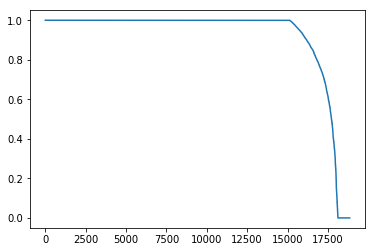

In [169]:
plt.plot(x_points,points)

In [ ]:
####################Fashion MNIST ####################################

In [217]:
import pandas as pd
fashion_data = pd.read_csv('fashion-mnist_test.csv')
targets_fashion = fashion_data.label.values
images = fashion_data.iloc[:,1:].values
images = images.astype(np.float)
# print(images.shape)
#f_X, f_y = fashion_data.iloc[:,:fashion_data.shape[1]-1], fashion_data.iloc[:,-1]
normalized_images = np.divide(images,255)

In [218]:
ed_mat_F_MNIST = euclidean_distances(normalized_images)

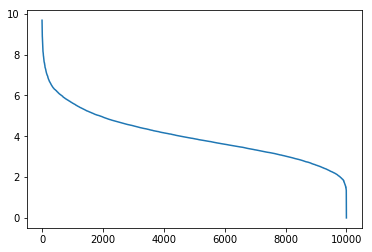

In [267]:
points=[]
for each_point in ed_mat_F_MNIST:
    c = np.sort(each_point)
    points.append(c[:5][1])
x_points = range(0,ed_mat_F_MNIST.shape[0])
points = np.sort(points)[::-1]
plt.plot(x_points,points)

In [268]:
#epsilon = 1, min points = 4
cluster_label_F_MNIST = DBScan(normalized_images,ed_mat_F_MNIST,3,4)
y_predict_F_MNIST = list(cluster_label_F_MNIST.values())
print("number of clusters:",len(set(y_predict_F_MNIST)))
counter = Counter(y_predict_F_MNIST)
print("distribution:",counter)

print("purity:",calculate_purity(y_predict_F_MNIST,targets_fashion,ed_mat_F_MNIST.shape[0]))
print("gini_index:",calculate_gini(y_predict_F_MNIST,targets_fashion,len(set(targets_fashion)),len(set(y_predict_F_MNIST)),ed_mat_F_MNIST.shape[0]))



number of clusters: 52
distribution: Counter({-1: 8601, 4: 623, 3: 247, 6: 145, 2: 55, 9: 33, 8: 30, 18: 19, 27: 15, 5: 14, 21: 10, 23: 9, 19: 8, 31: 8, 14: 8, 30: 8, 7: 7, 40: 6, 11: 6, 22: 6, 29: 6, 13: 6, 16: 6, 46: 6, 32: 6, 12: 5, 10: 5, 43: 5, 36: 5, 24: 5, 26: 5, 39: 5, 1: 4, 34: 4, 17: 4, 47: 4, 38: 4, 42: 4, 20: 4, 28: 4, 15: 4, 48: 4, 51: 4, 37: 4, 25: 4, 35: 4, 33: 4, 45: 4, 50: 4, 44: 3, 41: 3, 49: 3})
purity: 0.902072909220872
gini_index: 0.12680028055283132


In [ ]:
##epsilon = 3, min points = 4 was the best combination found for the sample data I am using. 
##epsilon = 3 was chosen based on the graph plotted against data points vs closest data points. 
##The knee dip was observed at 3 on the y-aix. 
##With different combinations of epsilon and min point, 
#(eps = 3 and min points = 4) was the best result giving the higher purity and lower gini index.

In [269]:
#epsilon = 1, min points = 4
cluster_label_F_MNIST = DBScan(normalized_images,ed_mat_F_MNIST,3.3,4)
y_predict_F_MNIST = list(cluster_label_F_MNIST.values())
print("number of clusters:",len(set(y_predict_F_MNIST)))
counter = Counter(y_predict_F_MNIST)
print("distribution:",counter)

print("purity:",calculate_purity(y_predict_F_MNIST,targets_fashion,ed_mat_F_MNIST.shape[0]))
print("gini_index:",calculate_gini(y_predict_F_MNIST,targets_fashion,len(set(targets_fashion)),len(set(y_predict_F_MNIST)),ed_mat_F_MNIST.shape[0]))


number of clusters: 68
distribution: Counter({-1: 7726, 2: 854, 1: 739, 4: 120, 17: 46, 13: 36, 9: 29, 8: 28, 29: 28, 10: 27, 20: 26, 3: 22, 35: 19, 5: 15, 41: 13, 26: 12, 11: 9, 44: 9, 56: 9, 16: 8, 31: 7, 7: 7, 43: 7, 45: 7, 28: 7, 12: 6, 32: 6, 40: 6, 15: 6, 34: 6, 18: 6, 62: 6, 24: 6, 50: 6, 14: 5, 19: 5, 33: 5, 38: 5, 36: 5, 59: 5, 6: 4, 25: 4, 54: 4, 46: 4, 61: 4, 65: 4, 52: 4, 49: 4, 30: 4, 21: 4, 39: 4, 27: 4, 64: 4, 37: 4, 42: 4, 57: 4, 66: 4, 48: 4, 60: 4, 67: 4, 51: 4, 53: 4, 63: 3, 58: 3, 23: 3, 22: 3, 47: 3, 55: 3})
purity: 0.748900615655233
gini_index: 0.2916137561007955


In [270]:
#epsilon = 1, min points = 4
cluster_label_F_MNIST = DBScan(normalized_images,ed_mat_F_MNIST,3.2,4)
y_predict_F_MNIST = list(cluster_label_F_MNIST.values())
print("number of clusters:",len(set(y_predict_F_MNIST)))
counter = Counter(y_predict_F_MNIST)
print("distribution:",counter)

print("purity:",calculate_purity(y_predict_F_MNIST,targets_fashion,ed_mat_F_MNIST.shape[0]))
print("gini_index:",calculate_gini(y_predict_F_MNIST,targets_fashion,len(set(targets_fashion)),len(set(y_predict_F_MNIST)),ed_mat_F_MNIST.shape[0]))



number of clusters: 59
distribution: Counter({-1: 8091, 1: 700, 2: 444, 7: 269, 4: 61, 14: 39, 10: 36, 24: 25, 17: 22, 19: 21, 12: 19, 8: 17, 3: 12, 28: 11, 44: 10, 9: 9, 42: 9, 40: 8, 5: 8, 21: 8, 39: 8, 34: 8, 33: 7, 16: 6, 32: 6, 36: 6, 31: 6, 49: 6, 11: 5, 41: 5, 30: 5, 15: 5, 43: 5, 27: 5, 29: 5, 35: 5, 48: 5, 6: 4, 20: 4, 23: 4, 58: 4, 45: 4, 13: 4, 53: 4, 26: 4, 18: 4, 25: 4, 37: 4, 22: 4, 52: 4, 57: 4, 38: 4, 54: 4, 56: 4, 55: 4, 51: 3, 46: 3, 50: 3, 47: 2})
purity: 0.8664222105814563
gini_index: 0.16378632926805345


In [266]:
#epsilon = 1, min points = 4
cluster_label_F_MNIST = DBScan(normalized_images,ed_mat_F_MNIST,3,3)
y_predict_F_MNIST = list(cluster_label_F_MNIST.values())
print("number of clusters:",len(set(y_predict_F_MNIST)))
counter = Counter(y_predict_F_MNIST)
print("distribution:",counter)

print("purity:",calculate_purity(y_predict_F_MNIST,targets_fashion,ed_mat_F_MNIST.shape[0]))
print("gini_index:",calculate_gini(y_predict_F_MNIST,targets_fashion,len(set(targets_fashion)),len(set(y_predict_F_MNIST)),ed_mat_F_MNIST.shape[0]))


number of clusters: 84
distribution: Counter({-1: 8405, 7: 644, 1: 259, 10: 150, 6: 60, 23: 35, 20: 31, 36: 20, 50: 17, 16: 16, 11: 15, 4: 13, 15: 11, 43: 9, 34: 9, 67: 9, 3: 8, 5: 8, 21: 8, 29: 8, 33: 8, 48: 8, 49: 8, 59: 7, 26: 7, 17: 7, 61: 7, 55: 7, 13: 6, 31: 6, 30: 6, 44: 6, 66: 6, 65: 5, 19: 5, 24: 5, 35: 5, 46: 5, 9: 4, 14: 4, 79: 4, 39: 4, 25: 4, 38: 4, 83: 4, 41: 4, 45: 4, 58: 4, 62: 4, 63: 4, 64: 4, 2: 3, 8: 3, 12: 3, 40: 3, 18: 3, 22: 3, 51: 3, 60: 3, 28: 3, 27: 3, 37: 3, 78: 3, 32: 3, 54: 3, 42: 3, 74: 3, 47: 3, 80: 3, 52: 3, 77: 3, 71: 3, 53: 3, 56: 3, 57: 3, 75: 3, 70: 3, 73: 3, 68: 3, 69: 3, 82: 3, 81: 3, 72: 3, 76: 3})
purity: 0.9047021943573668
gini_index: 0.12341949240935045


In [227]:
#epsilon = 1, min points = 4
cluster_label_F_MNIST = DBScan(normalized_images,ed_mat_F_MNIST,5.5,4)
y_predict_F_MNIST = list(cluster_label_F_MNIST.values())
print("number of clusters:",len(set(y_predict_F_MNIST)))
counter = Counter(y_predict_F_MNIST)
print("distribution:",counter)

print("purity:",calculate_purity(y_predict_F_MNIST,targets_fashion,ed_mat_F_MNIST.shape[0]))
print("gini_index:",calculate_gini(y_predict_F_MNIST,targets_fashion,len(set(targets_fashion)),len(set(y_predict_F_MNIST)),ed_mat_F_MNIST.shape[0]))


number of clusters: 9
distribution: Counter({1: 8709, -1: 1258, 5: 7, 7: 5, 2: 5, 3: 5, 4: 4, 8: 4, 6: 3})
purity: 0.11633493479752917
gini_index: 0.8951686523346352


In [228]:
#epsilon = 1, min points = 4
cluster_label_F_MNIST = DBScan(normalized_images,ed_mat_F_MNIST,5.1,4)
y_predict_F_MNIST = list(cluster_label_F_MNIST.values())
print("number of clusters:",len(set(y_predict_F_MNIST)))
counter = Counter(y_predict_F_MNIST)
print("distribution:",counter)

print("purity:",calculate_purity(y_predict_F_MNIST,targets_fashion,ed_mat_F_MNIST.shape[0]))
print("gini_index:",calculate_gini(y_predict_F_MNIST,targets_fashion,len(set(targets_fashion)),len(set(y_predict_F_MNIST)),ed_mat_F_MNIST.shape[0]))


number of clusters: 15
distribution: Counter({1: 8044, -1: 1890, 4: 13, 3: 7, 7: 6, 8: 5, 11: 5, 2: 4, 10: 4, 5: 4, 13: 4, 14: 4, 12: 4, 9: 3, 6: 3})
purity: 0.1279901356350185
gini_index: 0.8891344829087369


In [226]:
#epsilon = 1, min points = 4
cluster_label_F_MNIST = DBScan(normalized_images,ed_mat_F_MNIST,5,4)
y_predict_F_MNIST = list(cluster_label_F_MNIST.values())
print("number of clusters:",len(set(y_predict_F_MNIST)))
counter = Counter(y_predict_F_MNIST)
print("distribution:",counter)

print("purity:",calculate_purity(y_predict_F_MNIST,targets_fashion,ed_mat_F_MNIST.shape[0]))
print("gini_index:",calculate_gini(y_predict_F_MNIST,targets_fashion,len(set(targets_fashion)),len(set(y_predict_F_MNIST)),ed_mat_F_MNIST.shape[0]))



number of clusters: 12
distribution: Counter({1: 7835, -1: 2110, 3: 12, 5: 11, 2: 5, 9: 4, 10: 4, 4: 4, 11: 4, 8: 4, 7: 4, 6: 3})
purity: 0.12953105196451203
gini_index: 0.889022320575214


In [224]:
#epsilon = 1, min points = 4
cluster_label_F_MNIST = DBScan(normalized_images,ed_mat_F_MNIST,5,5)
y_predict_F_MNIST = list(cluster_label_F_MNIST.values())
print("number of clusters:",len(set(y_predict_F_MNIST)))
counter = Counter(y_predict_F_MNIST)
print("distribution:",counter)

print("purity:",calculate_purity(y_predict_F_MNIST,targets_fashion,ed_mat_F_MNIST.shape[0]))
print("gini_index:",calculate_gini(y_predict_F_MNIST,targets_fashion,len(set(targets_fashion)),len(set(y_predict_F_MNIST)),ed_mat_F_MNIST.shape[0]))


number of clusters: 5
distribution: Counter({1: 7782, -1: 2195, 4: 10, 3: 8, 2: 5})
purity: 0.12709801409352978
gini_index: 0.8916760058816062


In [225]:
#epsilon = 1, min points = 4
cluster_label_F_MNIST = DBScan(normalized_images,ed_mat_F_MNIST,6,5)
y_predict_F_MNIST = list(cluster_label_F_MNIST.values())
print("number of clusters:",len(set(y_predict_F_MNIST)))
counter = Counter(y_predict_F_MNIST)
print("distribution:",counter)

print("purity:",calculate_purity(y_predict_F_MNIST,targets_fashion,ed_mat_F_MNIST.shape[0]))
print("gini_index:",calculate_gini(y_predict_F_MNIST,targets_fashion,len(set(targets_fashion)),len(set(y_predict_F_MNIST)),ed_mat_F_MNIST.shape[0]))


number of clusters: 4
distribution: Counter({1: 9249, -1: 740, 2: 7, 3: 4})
purity: 0.10874730021598272
gini_index: 0.8984370667889778


In [ ]:
#epsilon = 1, min points = 4
cluster_label_F_MNIST = DBScan(normalized_images,ed_mat_F_MNIST,6,5)
y_predict_F_MNIST = list(cluster_label_F_MNIST.values())
print("number of clusters:",len(set(y_predict_F_MNIST)))
counter = Counter(y_predict_F_MNIST)
print("distribution:",counter)

print("purity:",calculate_purity(y_predict_F_MNIST,targets_fashion,ed_mat_F_MNIST.shape[0]))
print("gini_index:",calculate_gini(y_predict_F_MNIST,targets_fashion,len(set(targets_fashion)),len(set(y_predict_F_MNIST)),ed_mat_F_MNIST.shape[0]))


In [ ]:
####################Household ####################################

In [25]:
house_data = pd.read_csv('household_power_consumption.txt',sep=';',header=0,usecols=["Global_active_power", "Global_reactive_power"
                                                                            , "Voltage","Global_intensity","Sub_metering_1",
                                                                           "Sub_metering_2","Sub_metering_3"])

house_data = house_data.values

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [26]:

row = house_data.shape[0]
col = house_data.shape[1]
new_row = 0
for i in range(row):
    skip_row = False
    for j in range(col):
        if(house_data[i][j]=='?' or house_data[i][j]=='.' or math.isnan(float(house_data[i][j]))):
            skip_row = True
            break
    if skip_row == False:
           new_row+=1
cleaned_house_data = np.zeros((new_row,house_data.shape[1]))
k=0
for i in range(house_data.shape[0]):
    skip_row = False
    for j in range(house_data.shape[1]):
           if(house_data[i][j]=='?' or house_data[i][j]=='.' or math.isnan(float(house_data[i][j]))):
                  skip_row = True
                  break
    if skip_row == False:
            for l in range(house_data.shape[1]):
                  cleaned_house_data[k][l] = float(house_data[i][l])
            k+=1
              


In [30]:
ed_mat_housing = euclidean_distances(cleaned_house_data[:10000])

In [33]:
housing_sampled_data = cleaned_house_data[:10000]

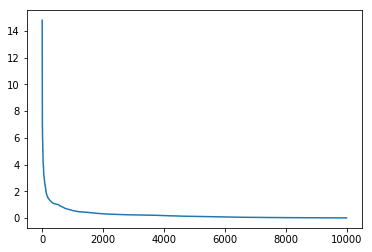

In [31]:
points=[]
for each_point in ed_mat_housing:
    c = np.sort(each_point)
    points.append(c[:5][1])
x_points = range(0,ed_mat_housing.shape[0])
points = np.sort(points)[::-1]
plt.plot(x_points,points)

In [34]:

cluster_label_housing = DBScan(housing_sampled_data,ed_mat_housing,1,5)
y_predict_housing = list(cluster_label_housing.values())
print("number of clusters:",len(set(y_predict_housing)))
counter = Counter(y_predict_housing)
print("distribution:",counter)


number of clusters: 73
distribution: Counter({11: 3533, 5: 1557, 4: 1223, -1: 1057, 14: 636, 2: 314, 13: 280, 10: 216, 12: 134, 21: 113, 24: 92, 8: 64, 35: 57, 15: 42, 36: 38, 32: 32, 3: 31, 42: 26, 16: 25, 9: 23, 25: 21, 31: 20, 18: 19, 23: 19, 37: 19, 27: 19, 34: 19, 41: 19, 44: 18, 49: 18, 40: 16, 17: 15, 22: 13, 58: 12, 6: 12, 69: 11, 39: 10, 64: 10, 28: 9, 59: 9, 45: 9, 7: 8, 26: 8, 1: 7, 19: 7, 33: 7, 38: 7, 47: 7, 54: 7, 70: 7, 20: 6, 29: 6, 30: 6, 43: 6, 46: 6, 48: 6, 56: 6, 60: 6, 62: 6, 65: 6, 57: 5, 51: 5, 61: 5, 55: 5, 50: 5, 52: 5, 53: 5, 63: 5, 66: 5, 67: 5, 68: 5, 71: 5, 72: 5})


In [ ]:
##epsilon = 1, min points = 5 was the best combination found for the sample data I am using. 
##epsilon = 0.9 was chosen based on the graph plotted against data points vs closest data points. 
##The knee dip was observed at 1 on the y-aix. 
##With different combinations of epsilon and min point, 
#(eps = 1 and min points = 5) was the best result giving the higher purity and lower gini index.

In [35]:

cluster_label_housing = DBScan(housing_sampled_data,ed_mat_housing,1,10)
y_predict_housing = list(cluster_label_housing.values())
print("number of clusters:",len(set(y_predict_housing)))
counter = Counter(y_predict_housing)
print("distribution:",counter)



number of clusters: 35
distribution: Counter({6: 3481, -1: 1661, 3: 1533, 2: 1198, 7: 614, 12: 269, 1: 193, 16: 186, 8: 101, 13: 101, 17: 83, 15: 76, 22: 57, 4: 47, 11: 39, 23: 36, 20: 26, 9: 25, 28: 24, 5: 20, 10: 19, 24: 19, 18: 19, 21: 19, 27: 18, 33: 18, 19: 16, 30: 16, 14: 15, 25: 14, 26: 13, 32: 12, 29: 12, 31: 10, 34: 10})
